<a href="https://colab.research.google.com/github/lukacvetkovic18/breast-cancer-detection/blob/main/OSiRV_Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from PIL import Image

import pandas as pd
import numpy as np
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import keras
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet169
from keras.layers import *
from keras import Model, Sequential
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [ ]:
dataset_path = '/content/drive/My Drive/dataset'

images = []
labels = []

for label in ['healthy', 'sick']:
    folder_path = os.path.join(dataset_path, label)
    for img_filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_filename)

        img = Image.open(img_path)

        img = img.resize((128, 128))

        images.append(np.array(img))
        labels.append(label)

images = np.array(images)
labels = np.array(labels)


In [ ]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, random_state=42, stratify=y_train_temp)

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

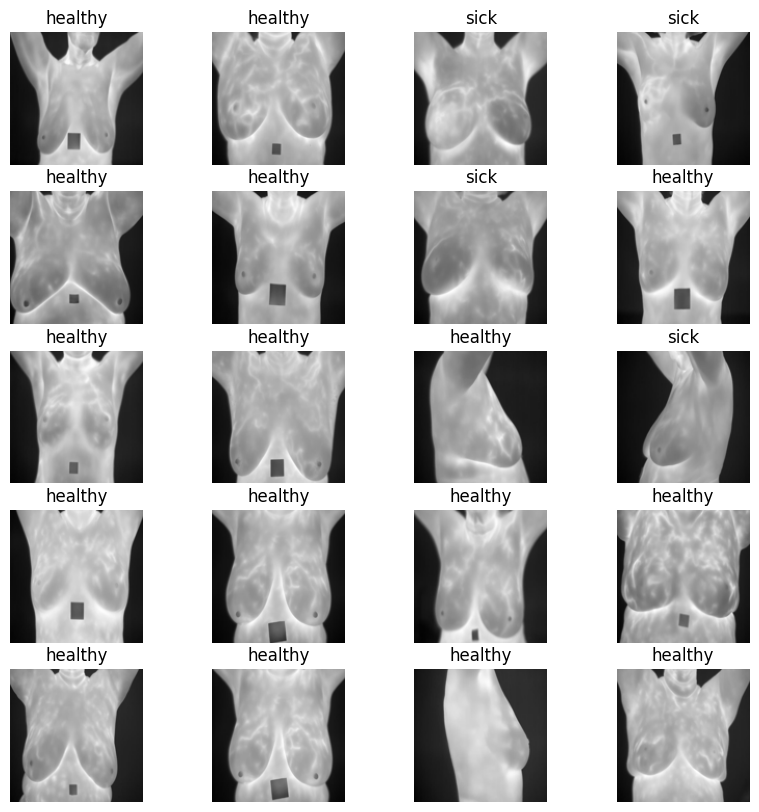

Train Set Label Distribution:
healthy: 80.56%
sick: 19.44%
Validation Set Label Distribution:
healthy: 80.57%
sick: 19.43%
Test Set Label Distribution:
healthy: 80.57%
sick: 19.43%


In [ ]:
def display_sample_images(images, labels, num_images=20):
    plt.figure(figsize=(10, 10))
    indices = random.sample(range(len(images)), num_images)
    for i, index in enumerate(indices):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[index])
        plt.title(labels[index])
        plt.axis("off")
    plt.show()

display_sample_images(images, labels)

def print_label_distribution(labels, dataset_name):
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    total = sum(counts)
    print(f"{dataset_name} Label Distribution:")
    for label, count in label_distribution.items():
        print(f"{label}: {count/total:.2%}")

print_label_distribution(y_train, "Train Set")
print_label_distribution(y_val, "Validation Set")
print_label_distribution(y_test, "Test Set")

# Simple Model

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val_encoded))

Epoch 1/50
105/105 [==============================] - 10s 34ms/step - loss: 0.5003 - accuracy: 0.8056 - val_loss: 0.3569 - val_accuracy: 0.8263
Epoch 2/50
105/105 [==============================] - 2s 22ms/step - loss: 0.2927 - accuracy: 0.8752 - val_loss: 0.2713 - val_accuracy: 0.8970
Epoch 3/50
105/105 [==============================] - 2s 20ms/step - loss: 0.2206 - accuracy: 0.9188 - val_loss: 0.2191 - val_accuracy: 0.9221
Epoch 4/50
105/105 [==============================] - 2s 19ms/step - loss: 0.1818 - accuracy: 0.9316 - val_loss: 0.2269 - val_accuracy: 0.9212
Epoch 5/50
105/105 [==============================] - 2s 19ms/step - loss: 0.1432 - accuracy: 0.9486 - val_loss: 0.1763 - val_accuracy: 0.9436
Epoch 6/50
105/105 [==============================] - 2s 19ms/step - loss: 0.1113 - accuracy: 0.9612 - val_loss: 0.1850 - val_accuracy: 0.9427
Epoch 7/50
105/105 [==============================] - 2s 19ms/step - loss: 0.0954 - accuracy: 0.9639 - val_loss: 0.1614 - val_accuracy: 0.939

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

35/35 [==============================] - 0s 8ms/step - loss: 0.3393 - accuracy: 0.9517
Test accuracy: 0.9516562223434448, Test loss: 0.33927398920059204


In [ ]:
model.save('simple_cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = load_model('simple_cnn_model.h5')

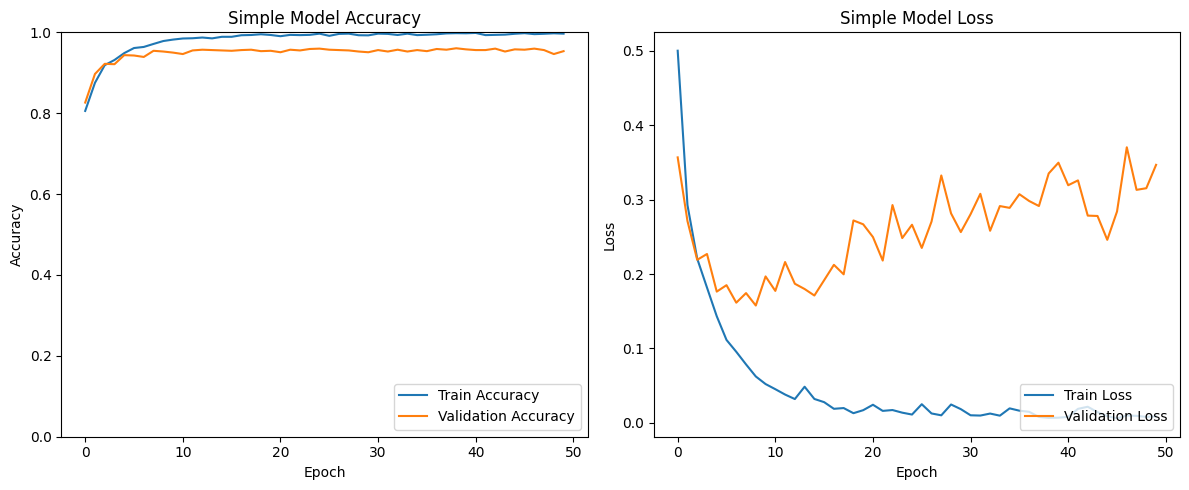

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Simple Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.legend(loc='lower right')

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Simple Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax1.set_ylim([0, 1])
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

35/35 [==============================] - 0s 11ms/step


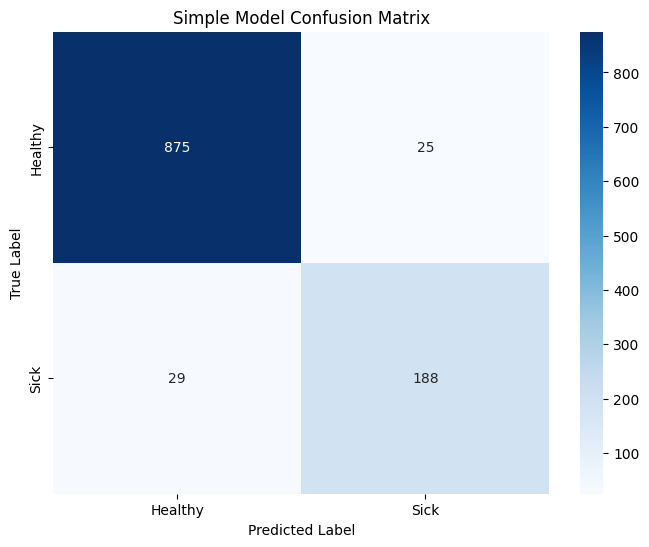

In [ ]:
predictions_prob = model.predict(X_test)
predictions = (predictions_prob > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(y_test_encoded, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Sick'],
            yticklabels=['Healthy', 'Sick'])

plt.title('Simple Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
TN, FP, FN, TP = conf_matrix.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Accuracy: 0.9517
Sensitivity (Recall): 0.8664
Specificity: 0.9722


In [ ]:
y_scores = predictions_prob.flatten()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_encoded, y_scores)

auc_keras = auc(fpr_keras, tpr_keras)

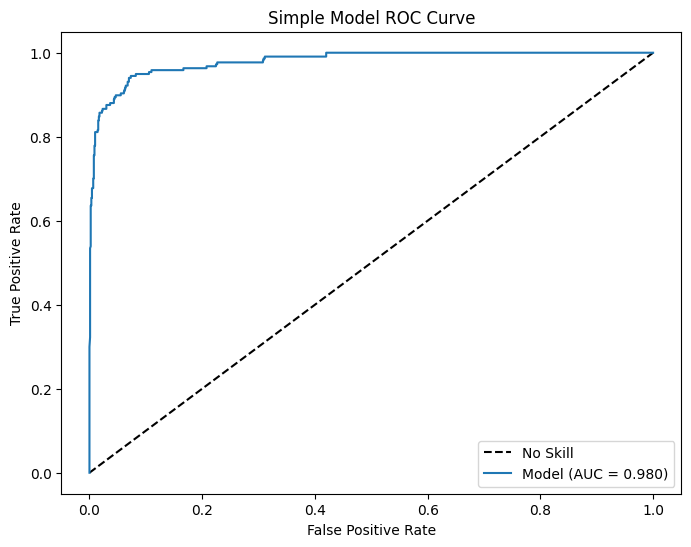

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.plot(fpr_keras, tpr_keras, label='Model (AUC = {:.3f})'.format(auc_keras))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Simple Model ROC Curve')
plt.legend(loc='best')
plt.show()

# ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.001)

model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
history_resnet50 = model_resnet50.fit(X_train, y_train_encoded, epochs=50, batch_size=32,
                             validation_data=(X_val, y_val_encoded))

Epoch 1/50
105/105 [==============================] - 14s 84ms/step - loss: 0.5178 - accuracy: 0.7990 - val_loss: 0.4724 - val_accuracy: 0.8057
Epoch 2/50
105/105 [==============================] - 5s 52ms/step - loss: 0.4694 - accuracy: 0.8056 - val_loss: 0.4596 - val_accuracy: 0.8057
Epoch 3/50
105/105 [==============================] - 7s 68ms/step - loss: 0.4541 - accuracy: 0.8071 - val_loss: 0.4265 - val_accuracy: 0.8066
Epoch 4/50
105/105 [==============================] - 6s 55ms/step - loss: 0.4372 - accuracy: 0.8098 - val_loss: 0.4448 - val_accuracy: 0.8057
Epoch 5/50
105/105 [==============================] - 6s 53ms/step - loss: 0.4181 - accuracy: 0.8128 - val_loss: 0.4019 - val_accuracy: 0.8084
Epoch 6/50
105/105 [==============================] - 5s 50ms/step - loss: 0.3973 - accuracy: 0.8193 - val_loss: 0.4391 - val_accuracy: 0.8111
Epoch 7/50
105/105 [==============================] - 5s 49ms/step - loss: 0.3842 - accuracy: 0.8244 - val_loss: 0.4150 - val_accuracy: 0.811

In [ ]:
test_loss_resnet50, test_acc_resnet50 = model_resnet50.evaluate(X_test, y_test_encoded)
print(f"ResNet50 Test accuracy: {test_acc_resnet50}, Test loss: {test_loss_resnet50}")

35/35 [==============================] - 1s 38ms/step - loss: 0.2839 - accuracy: 0.8756
ResNet50 Test accuracy: 0.8755595088005066, Test loss: 0.28393155336380005


In [ ]:
model_resnet50.save('resnet50_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_resnet50 = load_model('resnet50_model.h5')

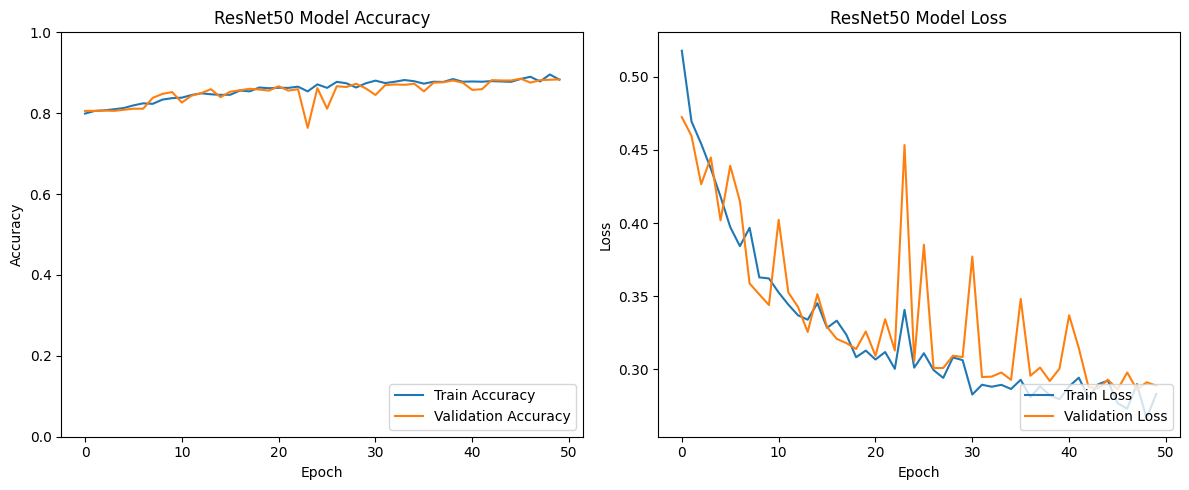

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history_resnet50.history['accuracy'], label='Train Accuracy')
ax1.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('ResNet50 Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.legend(loc='lower right')

ax2.plot(history_resnet50.history['loss'], label='Train Loss')
ax2.plot(history_resnet50.history['val_loss'], label='Validation Loss')
ax2.set_title('ResNet50 Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax1.set_ylim([0, 1])
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

35/35 [==============================] - 2s 35ms/step


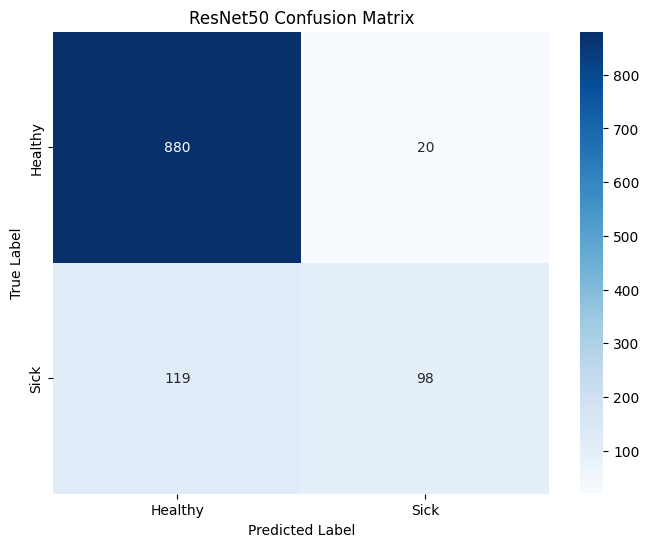

In [ ]:
predictions_prob = model_resnet50.predict(X_test)
predictions = (predictions_prob > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(y_test_encoded, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Sick'],
            yticklabels=['Healthy', 'Sick'])

plt.title('ResNet50 Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
TN, FP, FN, TP = conf_matrix.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Accuracy: 0.8756
Sensitivity (Recall): 0.4516
Specificity: 0.9778


In [ ]:
y_scores = predictions_prob.flatten()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_encoded, y_scores)

auc_keras = auc(fpr_keras, tpr_keras)

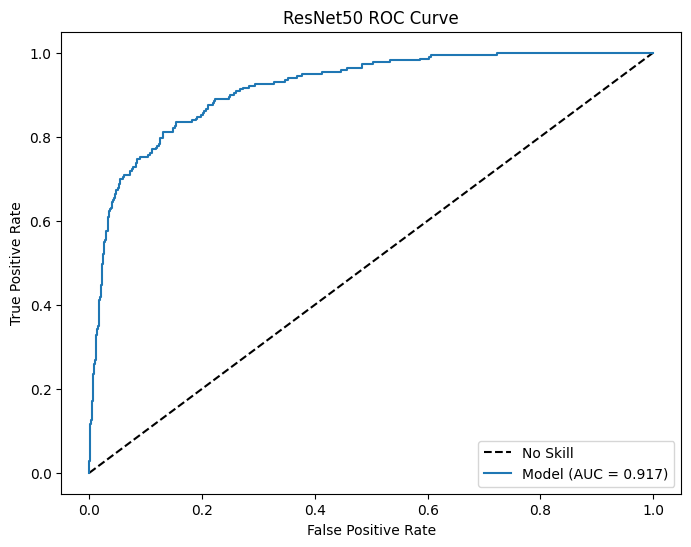

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.plot(fpr_keras, tpr_keras, label='Model (AUC = {:.3f})'.format(auc_keras))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet50 ROC Curve')
plt.legend(loc='best')
plt.show()

# MobileNet

In [ ]:
base_mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_mobilenet_model.layers:
    layer.trainable = False

x1 = base_mobilenet_model.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(1024, activation='relu')(x1)
predictions = Dense(1, activation='sigmoid')(x1)

model_mobilenet = Model(inputs=base_mobilenet_model.input, outputs=predictions)

model_mobilenet.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
history_mobilenet = model_mobilenet.fit(X_train, y_train_encoded, epochs=50, batch_size=32,
                                        validation_data=(X_val, y_val_encoded))

Epoch 1/50
105/105 [==============================] - 7s 42ms/step - loss: 0.4104 - accuracy: 0.8671 - val_loss: 0.2290 - val_accuracy: 0.9338
Epoch 2/50
105/105 [==============================] - 2s 21ms/step - loss: 0.1526 - accuracy: 0.9439 - val_loss: 0.1306 - val_accuracy: 0.9472
Epoch 3/50
105/105 [==============================] - 2s 21ms/step - loss: 0.0913 - accuracy: 0.9663 - val_loss: 0.1233 - val_accuracy: 0.9552
Epoch 4/50
105/105 [==============================] - 3s 25ms/step - loss: 0.0810 - accuracy: 0.9683 - val_loss: 0.1178 - val_accuracy: 0.9517
Epoch 5/50
105/105 [==============================] - 3s 26ms/step - loss: 0.0631 - accuracy: 0.9773 - val_loss: 0.0978 - val_accuracy: 0.9678
Epoch 6/50
105/105 [==============================] - 4s 34ms/step - loss: 0.0357 - accuracy: 0.9872 - val_loss: 0.1122 - val_accuracy: 0.9543
Epoch 7/50
105/105 [==============================] - 3s 27ms/step - loss: 0.0250 - accuracy: 0.9934 - val_loss: 0.0948 - val_accuracy: 0.9678

In [ ]:
test_loss, test_accuracy = model_mobilenet.evaluate(X_test, y_test_encoded)
print(f"MobileNet Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")

35/35 [==============================] - 1s 17ms/step - loss: 0.1018 - accuracy: 0.9731
MobileNet Test Accuracy: 0.9731423258781433, Test Loss: 0.1017562597990036


In [ ]:
model_mobilenet.save('mobilenet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_mobilenet = load_model('mobilenet_model.h5')

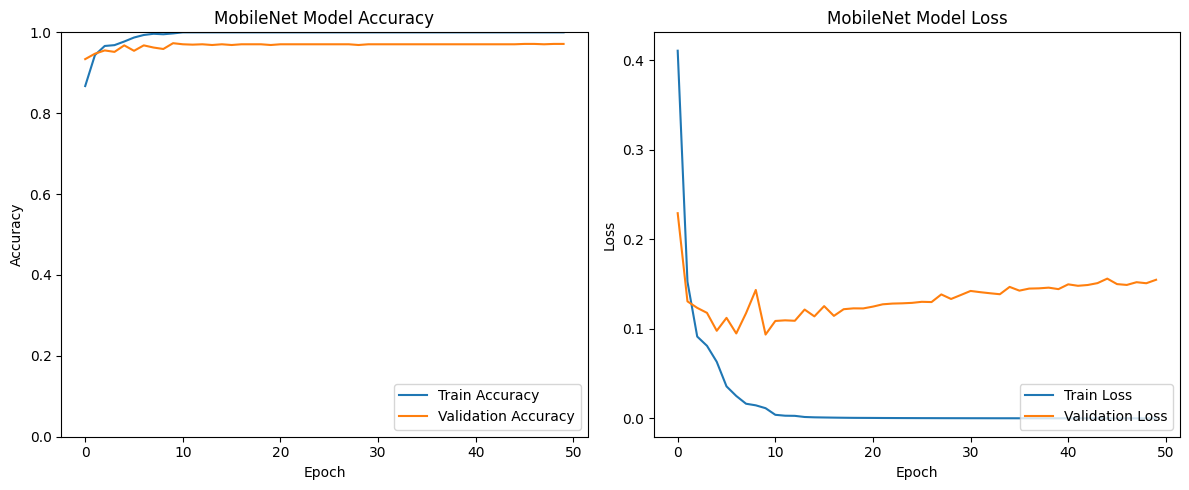

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
ax1.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('MobileNet Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.legend(loc='lower right')

ax2.plot(history_mobilenet.history['loss'], label='Train Loss')
ax2.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
ax2.set_title('MobileNet Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax1.set_ylim([0, 1])
ax2.legend(loc='lower right')


plt.tight_layout()
plt.show()

35/35 [==============================] - 1s 14ms/step


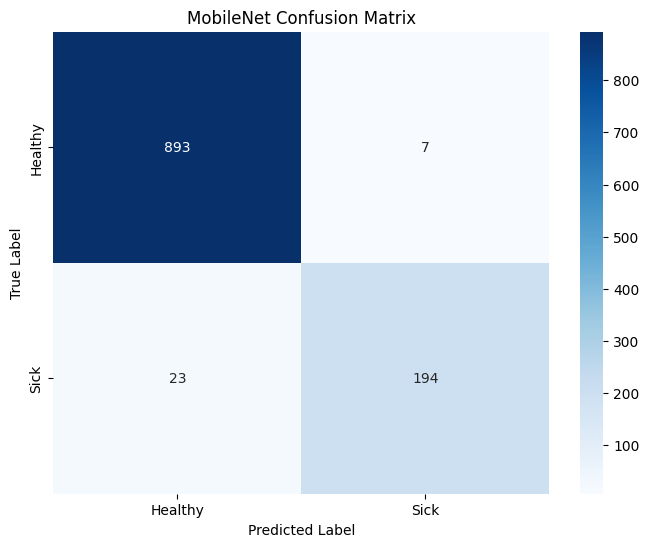

In [ ]:
# Get predictions
predictions_prob = model_mobilenet.predict(X_test)
predictions = (predictions_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

conf_matrix = confusion_matrix(y_test_encoded, predictions)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Sick'],
            yticklabels=['Healthy', 'Sick'])

plt.title('MobileNet Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
TN, FP, FN, TP = conf_matrix.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Accuracy: 0.9731
Sensitivity (Recall): 0.8940
Specificity: 0.9922


In [ ]:
y_scores = predictions_prob.flatten()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_encoded, y_scores)

auc_keras = auc(fpr_keras, tpr_keras)

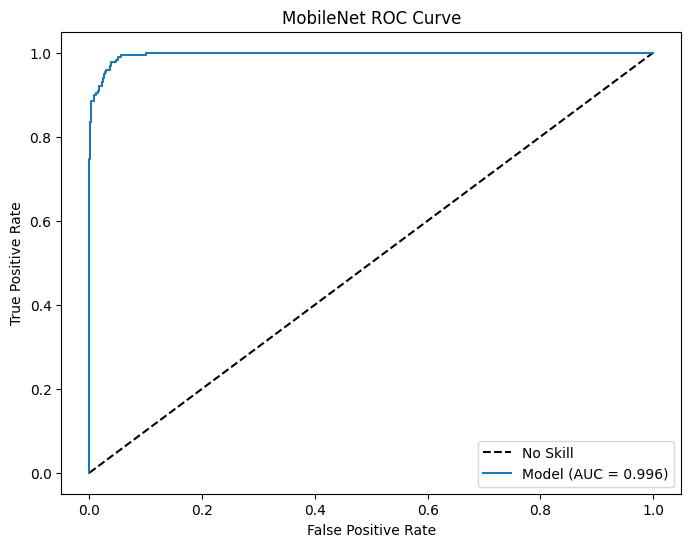

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.plot(fpr_keras, tpr_keras, label='Model (AUC = {:.3f})'.format(auc_keras))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MobileNet ROC Curve')
plt.legend(loc='best')
plt.show()

# VGG16

In [ ]:
base_vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_vgg16_model.layers[:-4]:
    layer.trainable = False

x2 = base_vgg16_model.output
x2 = GlobalAveragePooling2D()(x2)
x2 = Dense(1024, activation='relu')(x2)
predictions = Dense(1, activation='sigmoid')(x2)

model_vgg16 = Model(inputs=base_vgg16_model.input, outputs=predictions)

model_vgg16.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_vgg16 = model_vgg16.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_val, y_val_encoded))

Epoch 1/50
105/105 [==============================] - 19s 126ms/step - loss: 0.3528 - accuracy: 0.8480 - val_loss: 0.2181 - val_accuracy: 0.9150
Epoch 2/50
105/105 [==============================] - 8s 81ms/step - loss: 0.1547 - accuracy: 0.9409 - val_loss: 0.1543 - val_accuracy: 0.9320
Epoch 3/50
105/105 [==============================] - 9s 82ms/step - loss: 0.0774 - accuracy: 0.9678 - val_loss: 0.1236 - val_accuracy: 0.9481
Epoch 4/50
105/105 [==============================] - 8s 80ms/step - loss: 0.0758 - accuracy: 0.9719 - val_loss: 0.1047 - val_accuracy: 0.9633
Epoch 5/50
105/105 [==============================] - 9s 83ms/step - loss: 0.0288 - accuracy: 0.9904 - val_loss: 0.1087 - val_accuracy: 0.9624
Epoch 6/50
105/105 [==============================] - 8s 79ms/step - loss: 0.0153 - accuracy: 0.9958 - val_loss: 0.1477 - val_accuracy: 0.9606
Epoch 7/50
105/105 [==============================] - 8s 78ms/step - loss: 0.0098 - accuracy: 0.9970 - val_loss: 0.2469 - val_accuracy: 0.96

In [ ]:
test_loss, test_accuracy = model_vgg16.evaluate(X_test, y_test_encoded)
print(f"VGG16 Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")

35/35 [==============================] - 2s 43ms/step - loss: 0.1901 - accuracy: 0.9776
VGG16 Test Accuracy: 0.9776186347007751, Test Loss: 0.1901036947965622


In [ ]:
model_vgg16.save('vgg16_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_vgg16 = load_model('vgg16_model.h5')

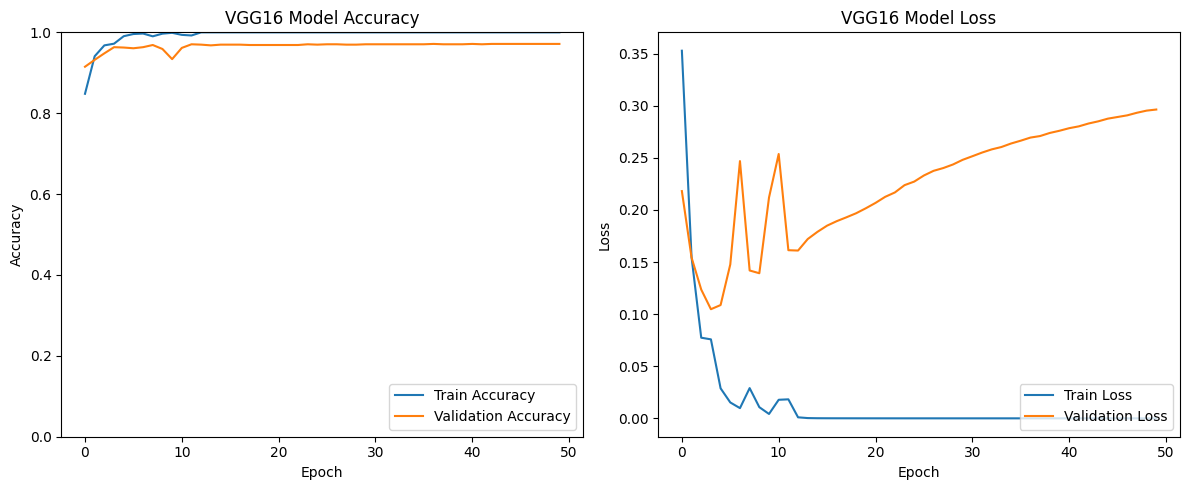

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
ax1.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('VGG16 Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.legend(loc='lower right')

ax2.plot(history_vgg16.history['loss'], label='Train Loss')
ax2.plot(history_vgg16.history['val_loss'], label='Validation Loss')
ax2.set_title('VGG16 Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax1.set_ylim([0, 1])
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

35/35 [==============================] - 2s 45ms/step


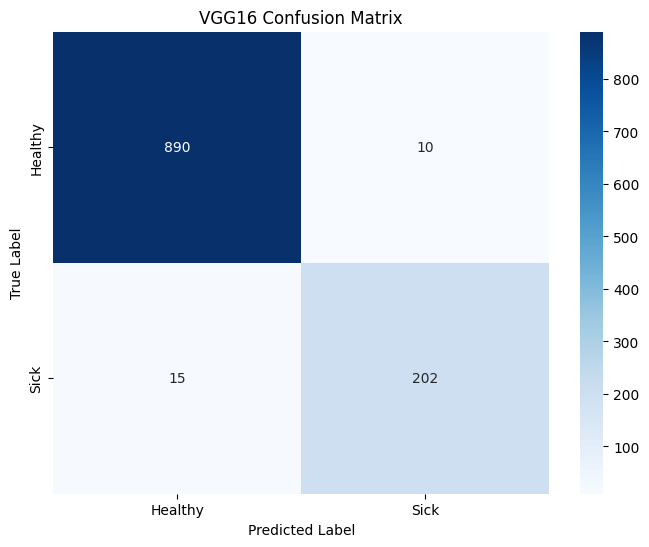

In [ ]:
predictions_prob = model_vgg16.predict(X_test)
predictions = (predictions_prob > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(y_test_encoded, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Sick'],
            yticklabels=['Healthy', 'Sick'])

plt.title('VGG16 Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
TN, FP, FN, TP = conf_matrix.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Accuracy: 0.9776
Sensitivity (Recall): 0.9309
Specificity: 0.9889


In [ ]:
y_scores = predictions_prob.flatten()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_encoded, y_scores)

auc_keras = auc(fpr_keras, tpr_keras)

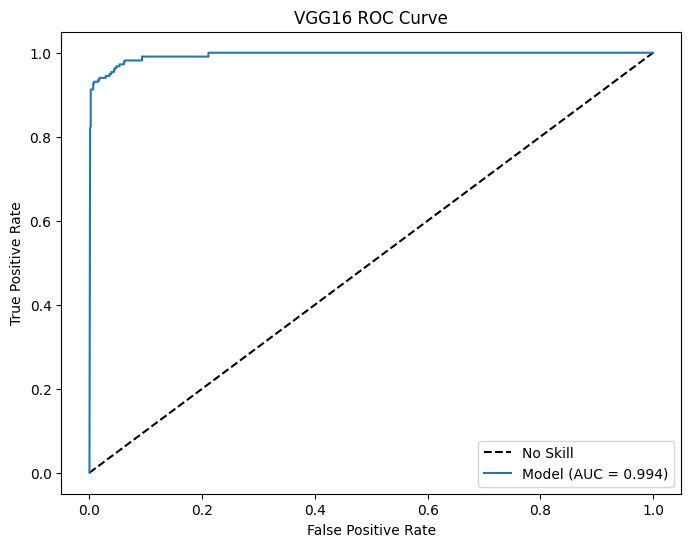

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.plot(fpr_keras, tpr_keras, label='Model (AUC = {:.3f})'.format(auc_keras))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16 ROC Curve')
plt.legend(loc='best')
plt.show()

# DenseNet169

In [ ]:
base_densenet169_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_densenet169_model.layers:
    layer.trainable = False

x3 = base_densenet169_model.output
x3 = GlobalAveragePooling2D()(x3)
x3 = Dense(1024, activation='relu')(x3)
predictions = Dense(1, activation='sigmoid')(x3)

model_densenet169 = Model(inputs=base_densenet169_model.input, outputs=predictions)

model_densenet169.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

51877672/51877672 [==============================] - 3s 0us/step


In [ ]:
history_densenet169 = model_densenet169.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_val, y_val_encoded))

Epoch 1/50
105/105 [==============================] - 30s 159ms/step - loss: 0.3028 - accuracy: 0.8794 - val_loss: 0.2643 - val_accuracy: 0.8970
Epoch 2/50
105/105 [==============================] - 6s 61ms/step - loss: 0.1813 - accuracy: 0.9373 - val_loss: 0.1855 - val_accuracy: 0.9355
Epoch 3/50
105/105 [==============================] - 7s 64ms/step - loss: 0.1360 - accuracy: 0.9597 - val_loss: 0.1534 - val_accuracy: 0.9499
Epoch 4/50
105/105 [==============================] - 6s 61ms/step - loss: 0.1145 - accuracy: 0.9669 - val_loss: 0.1464 - val_accuracy: 0.9454
Epoch 5/50
105/105 [==============================] - 7s 64ms/step - loss: 0.0953 - accuracy: 0.9722 - val_loss: 0.1473 - val_accuracy: 0.9391
Epoch 6/50
105/105 [==============================] - 7s 70ms/step - loss: 0.0806 - accuracy: 0.9785 - val_loss: 0.1239 - val_accuracy: 0.9526
Epoch 7/50
105/105 [==============================] - 7s 65ms/step - loss: 0.0674 - accuracy: 0.9794 - val_loss: 0.1176 - val_accuracy: 0.95

In [ ]:
test_loss, test_accuracy = model_densenet169.evaluate(X_test, y_test_encoded)
print(f"DenseNet169 Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")

35/35 [==============================] - 2s 51ms/step - loss: 0.1453 - accuracy: 0.9642
DenseNet169 Test Accuracy: 0.9641897678375244, Test Loss: 0.14533330500125885


In [ ]:
model_densenet169.save('densenet169_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_densenet169 = load_model('densenet169_model.h5')

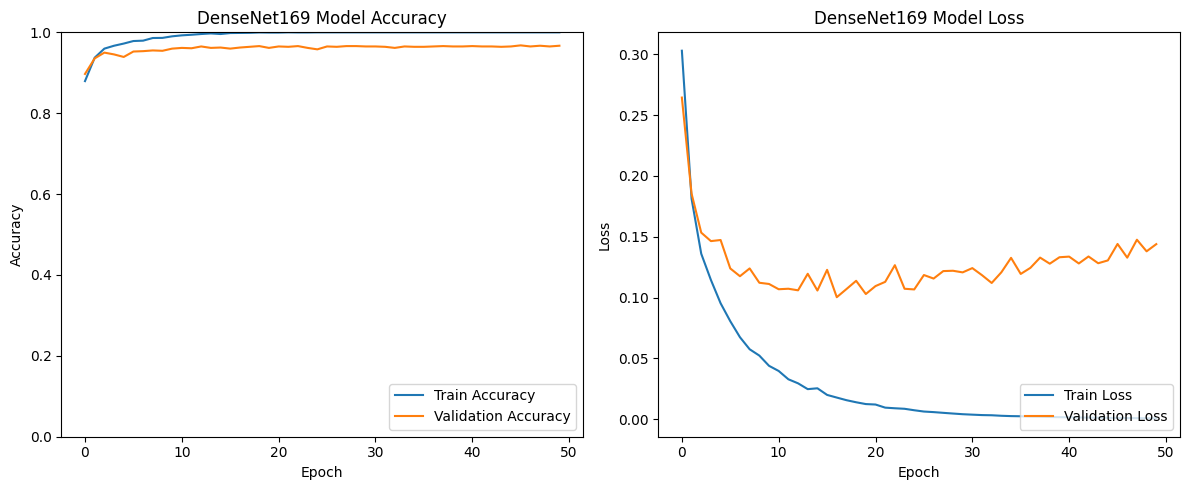

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history_densenet169.history['accuracy'], label='Train Accuracy')
ax1.plot(history_densenet169.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('DenseNet169 Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.legend(loc='lower right')

ax2.plot(history_densenet169.history['loss'], label='Train Loss')
ax2.plot(history_densenet169.history['val_loss'], label='Validation Loss')
ax2.set_title('DenseNet169 Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax1.set_ylim([0, 1])
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

35/35 [==============================] - 7s 55ms/step


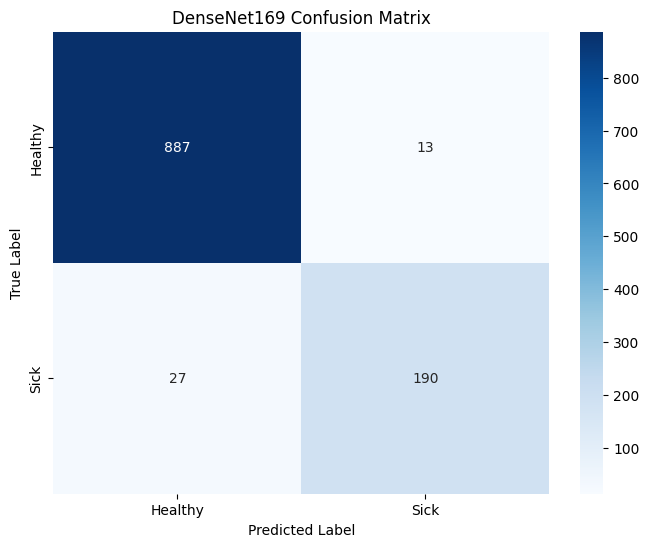

In [ ]:
predictions_prob = model_densenet169.predict(X_test)
predictions = (predictions_prob > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(y_test_encoded, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Sick'],
            yticklabels=['Healthy', 'Sick'])

plt.title('DenseNet169 Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
TN, FP, FN, TP = conf_matrix.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Accuracy: 0.9642
Sensitivity (Recall): 0.8756
Specificity: 0.9856


In [ ]:
y_scores = predictions_prob.flatten()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_encoded, y_scores)

auc_keras = auc(fpr_keras, tpr_keras)

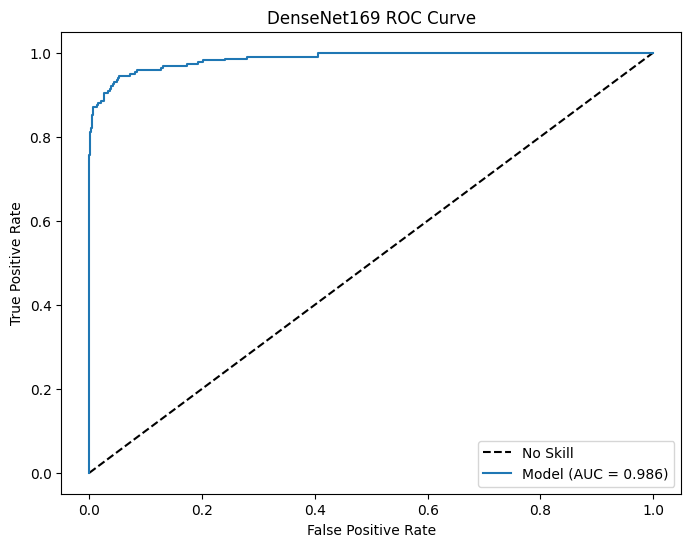

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.plot(fpr_keras, tpr_keras, label='Model (AUC = {:.3f})'.format(auc_keras))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DenseNet169 ROC Curve')
plt.legend(loc='best')
plt.show()